In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import make_grid

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [89]:
from gen_dataset import make_samples

class EdgeDataset(Dataset):
    def __init__(self, transform=None):
        """
        Custom dataset example for reading data from csv
        Args:
            images (numpy array (m,1,8,8)): images
            labels (numpy array (m,1)): 
            transform: pytorch transforms for transforms and tensor conversion
        """
        images, labels = make_samples(1000)
        self.images = images.reshape(-1,1,8,8).astype(np.float32)
        self.labels = labels.T.astype('long')
        self.transform = transform

    def __getitem__(self, idx):
        single_image_label = self.labels[idx]
        # Read each image at index
        single_image = self.images[idx]
        # Transform image to tensor
        if self.transform:
            single_image_transformed = self.transform(single_image)
            return (single_image_transformed, single_image_label)
        else:
            return (single_image, single_image_label)

    def __len__(self):
        return self.images.shape[0]

In [97]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = EdgeDataset(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True)

In [98]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(2, 2)
        
        self.model = nn.Sequential(
            nn.Linear(66,512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 64)
        c = self.label_emb(labels)
        x = torch.cat([x, torch.reshape(c,(-1,2))], 1)
        out = self.model(x)
        return out.squeeze()

In [99]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(2, 2)
        
        self.model = nn.Sequential(
            nn.Linear(22, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 64),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 20)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 8, 8)


In [100]:
generator = Generator()
discriminator = Discriminator()

In [101]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [102]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 20))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0,2,batch_size)))
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)

    g_loss = criterion(validity, Variable(torch.ones(batch_size)))
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()


In [103]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 20))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size)))
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

Starting epoch 0...
g_loss: 1.7301819324493408, d_loss: 0.19047565758228302


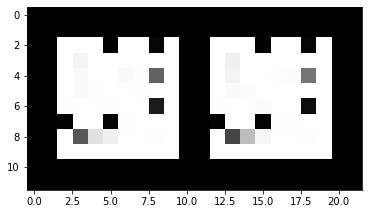

Starting epoch 1...
g_loss: 1.70975923538208, d_loss: 0.24822522699832916


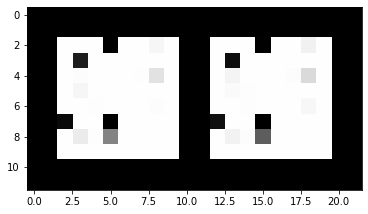

Starting epoch 2...
g_loss: 2.190633535385132, d_loss: 0.1779315024614334


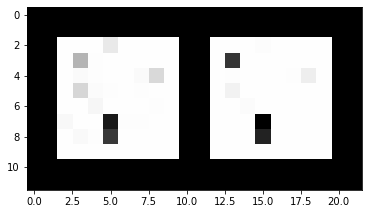

Starting epoch 3...
g_loss: 1.9390292167663574, d_loss: 0.2453220635652542


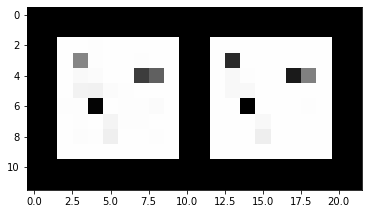

Starting epoch 4...
g_loss: 2.291761875152588, d_loss: 0.15019911527633667


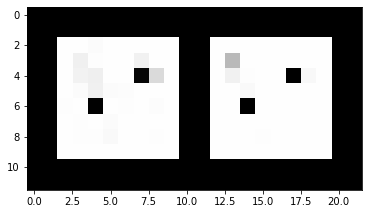

Starting epoch 5...
g_loss: 1.6088063716888428, d_loss: 0.2730885148048401


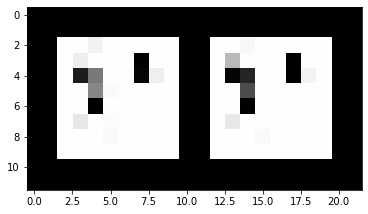

Starting epoch 6...
g_loss: 1.904817819595337, d_loss: 0.15422423183918


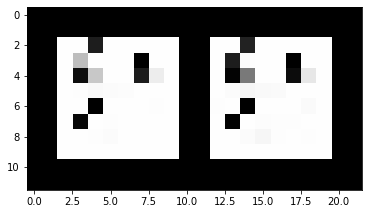

Starting epoch 7...
g_loss: 3.001737356185913, d_loss: 0.09953934699296951


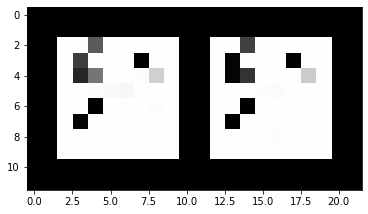

Starting epoch 8...
g_loss: 2.940446376800537, d_loss: 0.06473975628614426


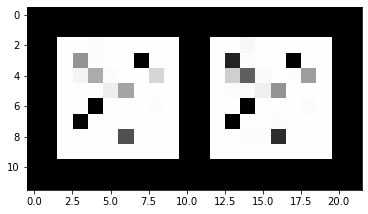

Starting epoch 9...
g_loss: 2.8783397674560547, d_loss: 0.027931176126003265


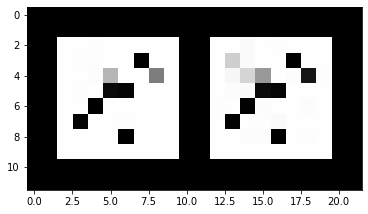

Starting epoch 10...
g_loss: 3.3463921546936035, d_loss: 0.07086223363876343


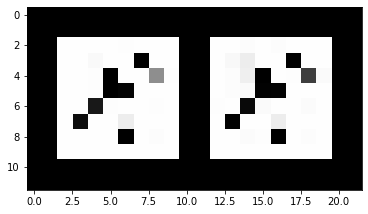

Starting epoch 11...
g_loss: 2.7947309017181396, d_loss: 0.08265650272369385


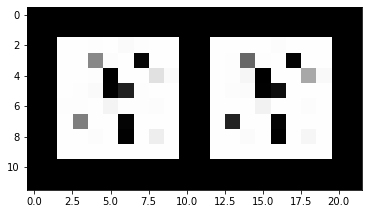

Starting epoch 12...
g_loss: 2.5776772499084473, d_loss: 0.07947245240211487


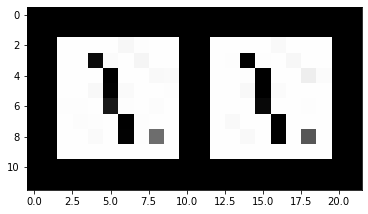

Starting epoch 13...
g_loss: 2.3293800354003906, d_loss: 0.08331216871738434


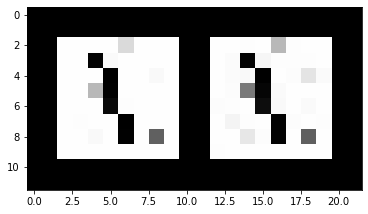

Starting epoch 14...
g_loss: 2.696411609649658, d_loss: 0.1070900559425354


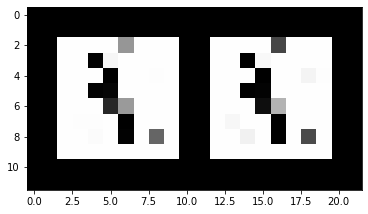

Starting epoch 15...
g_loss: 3.1268250942230225, d_loss: 0.06432656198740005


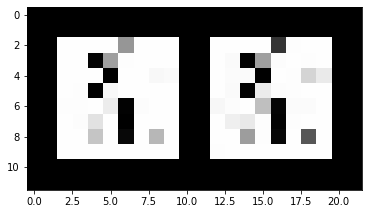

Starting epoch 16...
g_loss: 3.7262825965881348, d_loss: 0.04199632629752159


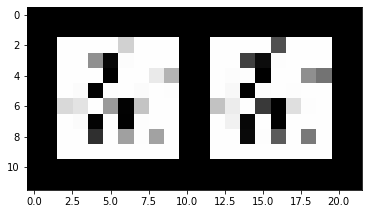

Starting epoch 17...
g_loss: 3.056238889694214, d_loss: 0.12556639313697815


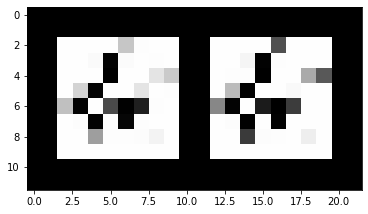

Starting epoch 18...
g_loss: 3.2824513912200928, d_loss: 0.03664258122444153


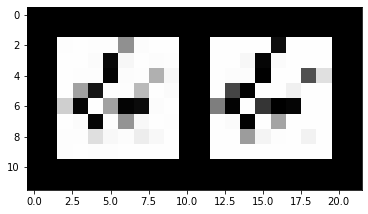

Starting epoch 19...
g_loss: 3.1327321529388428, d_loss: 0.038520410656929016


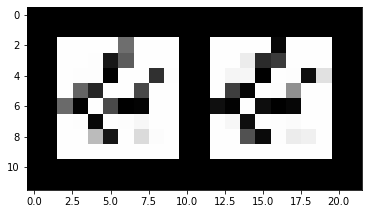

Starting epoch 20...
g_loss: 3.7992801666259766, d_loss: 0.029341477900743484


KeyboardInterrupt: 

In [105]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images)
        labels = Variable(labels)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(2, 20))
    labels = Variable(torch.LongTensor(np.arange(2)))
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=2, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()